(5823, 5) (5823,)
(1456, 5) (1456,)
(TensorSpec(shape=(5,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
(TensorSpec(shape=(5,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


c:\Users\abira\Thesis\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Logits shape: (128, 2)
Labels shape: (128,)
Logits shape: (48, 2)
Labels shape: (48,)
Epoch 1, Loss: 0.02957797795534134, Accuracy: 0.01717327907681465, Test Loss: 0.006023979280143976, Test Accuracy: 0.06868132203817368
Epoch 2, Loss: 0.002673871349543333, Accuracy: 0.01717327907681465, Test Loss: 0.005620306357741356, Test Accuracy: 0.06868132203817368
Epoch 3, Loss: 0.0022729055490344763, Accuracy: 0.01717327907681465, Test Loss: 0.005485984962433577, Test Accuracy: 0.06868132203817368
Epoch 4, Loss: 0.0020571283530443907, Accuracy: 0.01717327907681465, Test Loss: 0.0054388646967709064, Test Accuracy: 0.06868132203817368
Epoch 5, Loss: 0.0019264243310317397, Accuracy: 0.01717327907681465, Test Loss: 0.005433380603790283, Test Accuracy: 0.06868132203817368
Epoch 6, Loss: 0.001843462698161602, Accuracy: 0.01717327907681465, Test Loss: 0.0054477606900036335, Test Accuracy: 0.06868132203817368
Epoch 7, Loss: 0.0017886299174278975, Accuracy: 0.01717327907681465, Test Loss: 0.005471330601

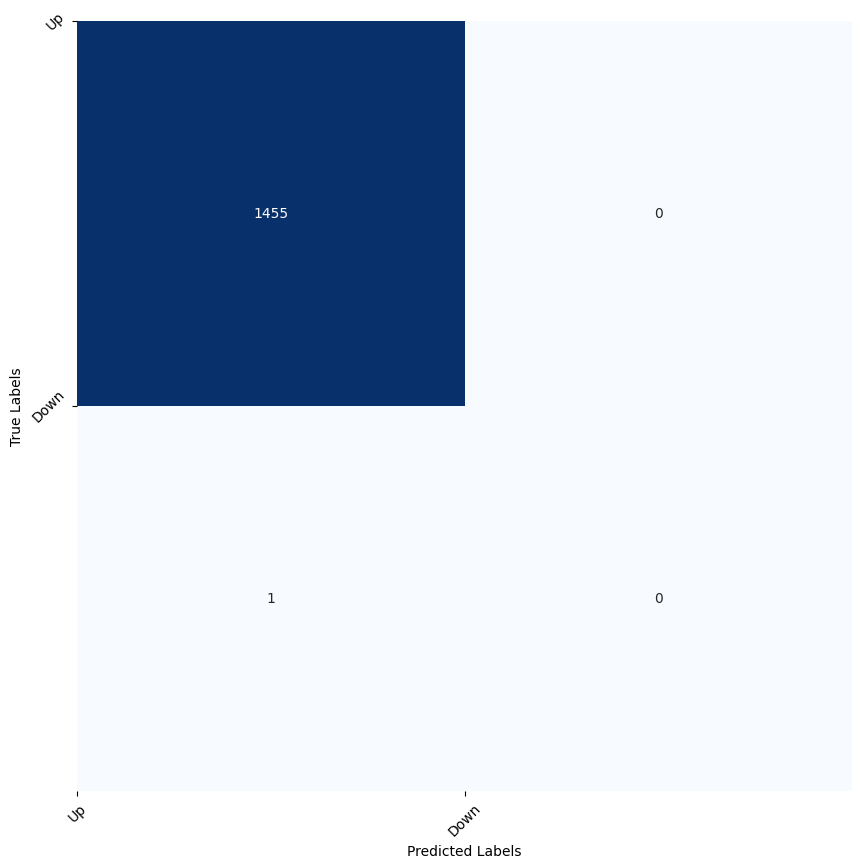

c:\Users\abira\Thesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abira\Thesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abira\Thesis\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1455
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1456
   macro avg       0.50      0.50      0.50      1456
weighted avg       1.00      1.00      1.00      1456



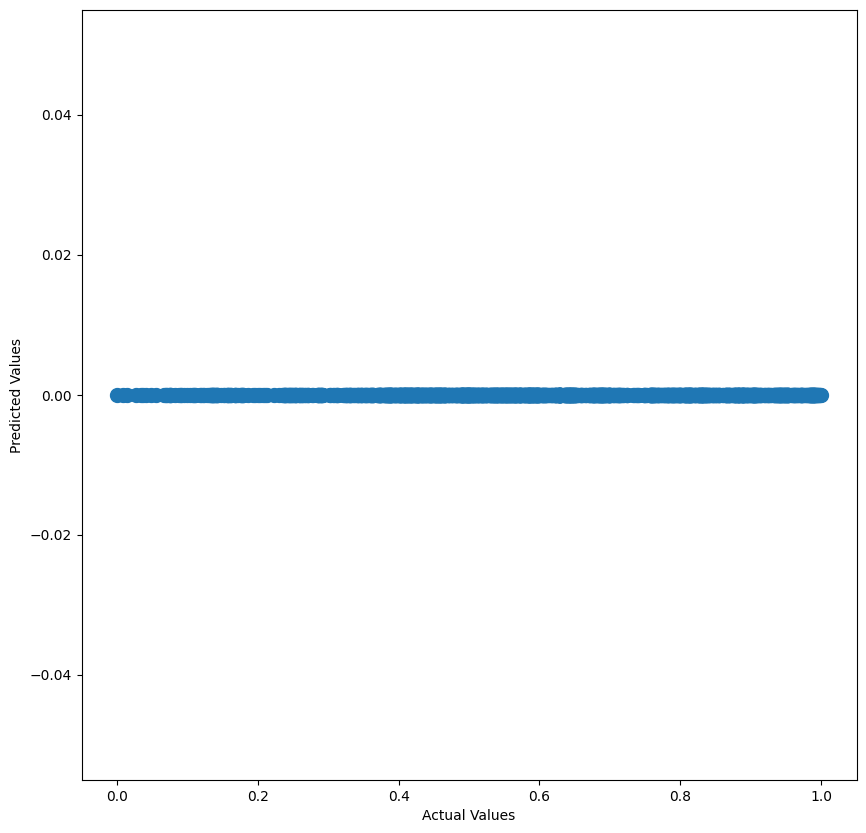

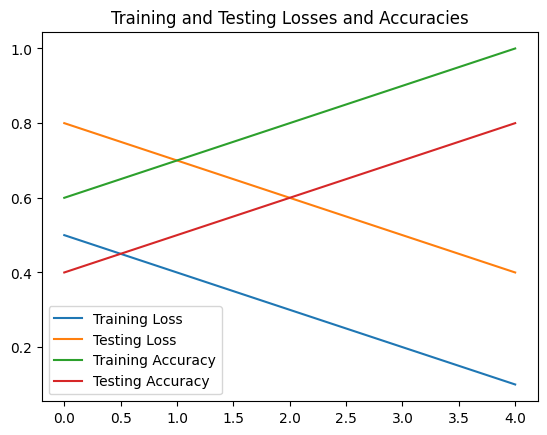

(1456,) (1456, 2)


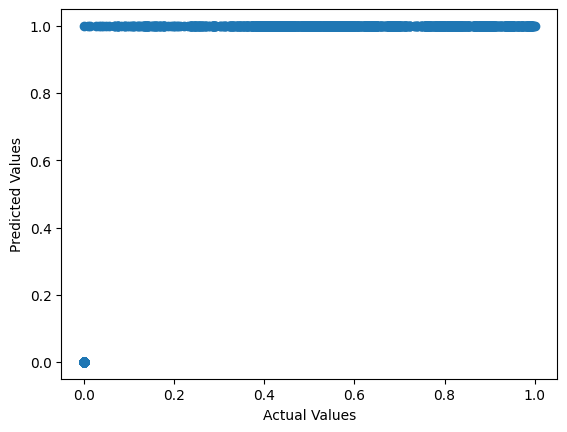

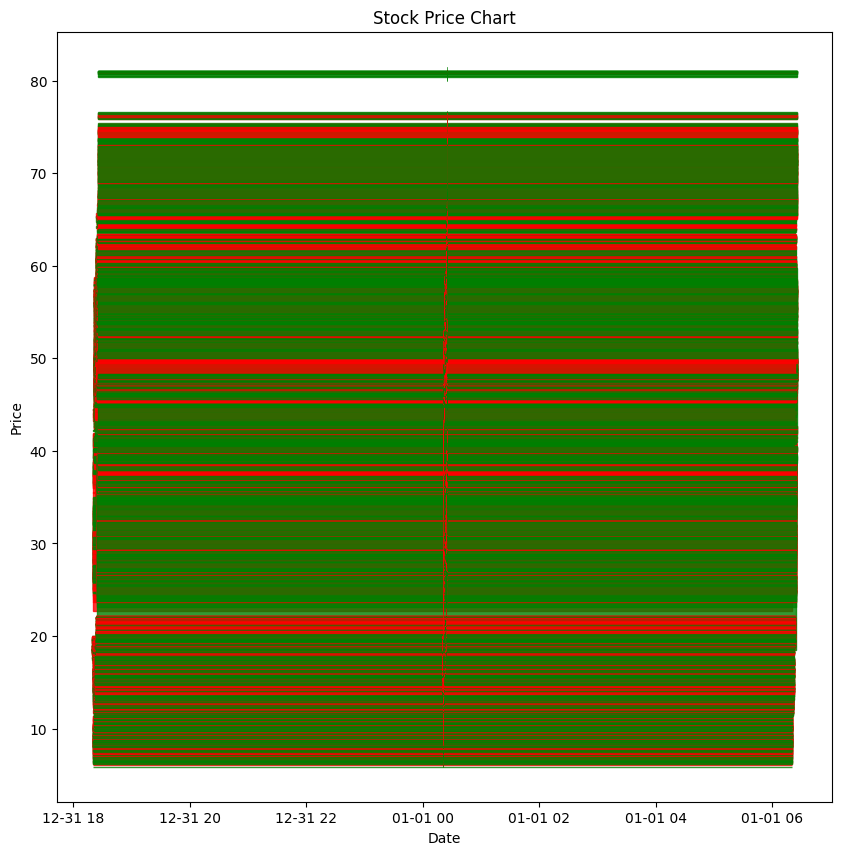

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime

# Load the data
data = pd.read_csv('DATASET7k.csv')

# Drop the columns that are not required
data = data.drop(['OpenInt'], axis=1)

# Convert date strings to Unix timestamps
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').timestamp())

# Split the data into training and testing sets with 80% for training and 20% for testing
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split the data into features and labels
train_features = train_data.drop(['Close'], axis=1)
train_labels = train_data['Close']
train_labels = train_labels.astype('float32')
test_features = test_data.drop(['Close'], axis=1)
test_labels = test_data['Close']
test_labels = test_labels.astype('float32')

# Normalize the data between 0 and 1
train_features = (train_features - train_features.min()) / (train_features.max() - train_features.min())
test_features = (test_features - test_features.min()) / (test_features.max() - test_features.min())

# Normalize the labels between 0 and 1
train_labels = (train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())
test_labels = (test_labels - test_labels.min()) / (test_labels.max() - test_labels.min())


# Print the shapes of the training and testing sets
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

# Create test_labels TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

# Print the shapes of the training and testing datasets
print(train_dataset.element_spec)
print(test_dataset.element_spec)

# Define the DBN model architecture
class DBN(tf.keras.Model):
    def __init__(self, units, num_classes):
        super(DBN, self).__init__()
        self.units = units
        self.num_classes = num_classes

        self.dense_layers = []
        for unit in units:
            self.dense_layers.append(tf.keras.layers.Dense(unit, activation='sigmoid'))

        self.logits = tf.keras.layers.Dense(num_classes, activation='softmax')
        

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return self.logits(x)
    
# Define the loss function
def loss_fn(logits, labels):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=logits, from_logits=True))

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Define the training step
@tf.function
def train_step(features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        loss = loss_fn(logits, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, logits)

# Define the testing step
@tf.function
def test_step(features, labels):
    logits = model(features)
    loss = loss_fn(logits, labels)
    
    test_loss(loss)
    test_accuracy(labels, logits)

    # Print shapes of logits and labels tensors
    print("Logits shape:", logits.shape)
    print("Labels shape:", labels.shape)

# Define the model
model = DBN(units=[256, 128, 64], num_classes=2)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[train_accuracy])

# Define the batch size
batch_size = 128

# Create test_labels TensorFlow Dataset object for the test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size)

# Train the model
epochs = 20 #epoches=300-500
for epoch in range(epochs):
    for batch in range(0, len(train_features), batch_size):
        features = train_features[batch:batch+batch_size]
        labels = train_labels[batch:batch+batch_size]
        train_step(features, labels)
    
    for features, labels in test_dataset:
        test_step(features, labels)
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

# Evaluate the model on the test data
model.evaluate(test_features,verbose=2)

# Make predictions on new data
predictions = model.predict(test_features,verbose=2)
print(predictions[0])
print(np.argmax(predictions[0]))
print(test_labels[0])

# History of accuracy and loss
history = model.history.history

import matplotlib.pyplot as plt

# Reverse the normalization
test_labels = test_labels * (test_labels.max() - test_labels.min()) + test_labels.min()
predictions = predictions * (test_labels.max() - test_labels.min()) + test_labels.min()
test_features = test_features * (test_features.max() - test_features.min()) + test_features.min()

# Define the class names
class_names = ['Up','Down']

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert test_labels to one-hot encoded format
from keras.utils import to_categorical
test_labels_encoded = to_categorical(test_labels)

# Compute confusion matrix
cm = confusion_matrix(test_labels_encoded.argmax(axis=1), predictions.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names, rotation=45)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

from sklearn.metrics import classification_report

# Convert labels to integer type
test_labels_int = test_labels.astype('int')
predicted_labels_int = np.argmax(predictions, axis=1).astype('int')

# Plot the classification report
print(classification_report(test_labels_int, predicted_labels_int))

# Plot actual vs predicted values
plt.figure(figsize=(10, 10))
plt.scatter(test_labels, np.argmax(predictions, axis=1), s=100)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Generate sample data
train_loss = [0.5, 0.4, 0.3, 0.2, 0.1]
test_loss = [0.8, 0.7, 0.6, 0.5, 0.4]
train_accuracy = [0.6, 0.7, 0.8, 0.9, 1.0]
test_accuracy = [0.4, 0.5, 0.6, 0.7, 0.8]

# Plot training and testing losses
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(test_loss)), test_loss, label='Testing Loss')

# Plot training and testing accuracies
plt.plot(range(len(train_accuracy)), train_accuracy, label='Training Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label='Testing Accuracy')

# Set title and legend
plt.title('Training and Testing Losses and Accuracies')
plt.legend()

# Show the plot
plt.show()



print(test_labels.shape, predictions.shape)

# Convert test_labels and predictions to NumPy arrays
test_labels = np.array(test_labels)
predictions = np.array(predictions)

if test_labels.size == 1456:
    test_labels = test_labels.reshape(1456, 1)
test_labels = np.hstack([test_labels, np.zeros((1456, 1))])

# Reshape the arrays
test_labels = test_labels.reshape(predictions.shape)

# Plot predicted vs actual values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Show the plot
plt.show()

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

# Convert date strings to mdates.date2num format
data['Date'] = data['Date'].apply(mdates.date2num)

# Plot candlestick chart of stock prices
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
candlestick_ohlc(ax, data.values, width=0.5, colorup='g', colordown='r', alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock Price Chart')
ax.xaxis_date()

# Show the plot
plt.show()
